# Notebook: Load, Clean, and Analyze Campus Incident Data
This notebook performs data loading and cleaning (Notebook 2) and analysis + visualization (Notebook 3) for the campus incidents dataset. It also displays the corrected Jewish-holiday metrics and matched raw rows produced by the pipeline.

In [1]:
# Cell 1: imports and helper functions
import os
import re
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Nice defaults
sns.set(style='whitegrid', context='notebook')
pd.set_option('display.max_columns', 200)

# Paths
ROOT = Path('..') if Path('.').resolve().name != 'AntisemitismTrends' else Path('.')
DATA_DIR = Path('../data').resolve() if (Path('../data').exists()) else Path('data')
OUT_DIR = Path('../outputs').resolve() if (Path('../outputs').exists()) else Path('outputs')
OUT_DIR.mkdir(parents=True, exist_ok=True)

RAW_CSV = DATA_DIR / 'campus_reports.csv'
CLEAN_PARQUET = OUT_DIR / 'campus_reports.cleaned.parquet'
METRICS_CSV = OUT_DIR / 'protest_jewish_holiday_metrics_corrected.csv'
MATCHED_RAW = OUT_DIR / 'inspection_jh_raw_matches.csv'
PR_PLOT = OUT_DIR / 'pr_curve_best_holiday_model.png'
RATE_PLOT = OUT_DIR / 'protest_rate_by_jewish_holiday_corrected.png'

print('Paths set:', RAW_CSV, CLEAN_PARQUET, METRICS_CSV)

Paths set: /Users/ainsleyfreedman/projects/AntisemitismTrends/data/campus_reports.csv /Users/ainsleyfreedman/projects/AntisemitismTrends/outputs/campus_reports.cleaned.parquet /Users/ainsleyfreedman/projects/AntisemitismTrends/outputs/protest_jewish_holiday_metrics_corrected.csv


## Notebook 2 — Load CSV and quick inspection
Read the CSV with safe options, detect malformed lines (comment prefix `//` accepted), and show initial diagnostics.

In [2]:
# 2.1 Load with protective options
read_opts = dict(
    sep=',',
    quotechar='"',
    encoding='utf-8',
    dtype=str,
    keep_default_na=True,
    na_values=['', 'NA', 'N/A'],
    engine='python'  # more tolerant for tricky rows
)

# Some files have '//' comment sections in exported excerpts; support comment prefix
with open(RAW_CSV, 'r', encoding='utf-8') as f:
    sample = ''.join([next(f) for _ in range(10)])
print('Sample header lines:\n', sample)

raw = pd.read_csv(RAW_CSV, **read_opts, comment='//')
print('Loaded raw shape:', raw.shape)
print(raw.dtypes)
raw.head(5)

Sample header lines:
 Date of Incident,City of Incident,State of Incident,Incident Type,Description,College/University
7/11/23,Northridge,California,Vandalism,"Graffiti was found in a bathroom at California State University, Northridge, that included the phone number of a Hillel-affiliated student and read: ""Please spam [phone number]. He's a Zionist. Hurt his feelings. Free Palestine!""","California State University, Northridge"
8/11/23,New Haven,Connecticut,Harassment,"Patriot Front, a white supremacist group, distributed propaganda at Yale University that read: ""Strong families make strong nations,"" ""Reclaim America,"" ""No Zionists in government, we serve one nation,"" ""America first"" and ""Not stolen, conquered.""",Yale University
8/21/23,San Francisco,California,Protest/Action,"A banner stating: ""Zionism is Racism"" was displayed at San Francisco State University.",San Francisco State University
8/31/23,Chicago,Illinois,Harassment,"During an argument, a University of Illin

,Date of Incident,City of Incident,State of Incident,Incident Type,Description,College/University
0,7/11/23,Northridge,California,Vandalism,Graffiti was found in a bathroom at California...,"California State University, Northridge"
1,8/11/23,New Haven,Connecticut,Harassment,"Patriot Front, a white supremacist group, dist...",Yale University
2,8/21/23,San Francisco,California,Protest/Action,"A banner stating: ""Zionism is Racism"" was disp...",San Francisco State University
3,8/31/23,Chicago,Illinois,Harassment,"During an argument, a University of Illinois, ...","University of Illinois, Chicago"
4,9/4/23,Cambridge,Massachusetts,Protest/Action,Anti-Israel protesters at Harvard University d...,Harvard University


## Notebook 2 — Parse dates and enforce dtypes
Parse `Date of Incident` to datetime, show parsing failures, and cast categorical columns.

In [3]:
# 2.2 Parse dates
date_col = 'Date of Incident'
raw[date_col+'_parsed'] = pd.to_datetime(raw[date_col], format='%m/%d/%y', errors='coerce')
# fallback: try infer for the rows that failed
mask_fail = raw[date_col+'_parsed'].isna()
if mask_fail.any():
    raw.loc[mask_fail, date_col+'_parsed'] = pd.to_datetime(raw.loc[mask_fail, date_col], errors='coerce', dayfirst=False)

print('Parsed datetimes: total failures =', raw[date_col+'_parsed'].isna().sum())
raw.loc[raw[date_col+'_parsed'].isna(), [date_col]].head(10)

# Enforce categorical dtypes
cat_cols = ['State of Incident', 'Incident Type', 'College/University']
for c in cat_cols:
    if c in raw.columns:
        raw[c] = raw[c].astype('category')

raw[date_col+'_parsed'].head()

Parsed datetimes: total failures = 0


0   2023-07-11
1   2023-08-11
2   2023-08-21
3   2023-08-31
4   2023-09-04
Name: Date of Incident_parsed, dtype: datetime64[ns]

## Notebook 2 — Clean Description text (quotes, escape sequences, PII)
Normalize the `Description` field, mask phone numbers and emails, compute description length and flags.

In [4]:
# 2.3 Clean Description
desc_col = 'Description'
if desc_col in raw.columns:
    def mask_pii(text):
        if pd.isna(text):
            return text
        t = str(text)
        # unescape doubled quotes
        t = t.replace('""', '"')
        # mask phone numbers
        t = re.sub(r'\b\d{3}[-.\s]?\d{3}[-.\s]?\d{4}\b', '[PHONE]', t)
        # mask emails
        t = re.sub(r'[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}', '[EMAIL]', t)
        return t.strip()

    raw['description_clean'] = raw[desc_col].apply(mask_pii)
    raw['description_len'] = raw['description_clean'].fillna('').str.len()
    raw['description_empty'] = raw['description_len'] == 0
    display(raw[[desc_col, 'description_clean', 'description_len', 'description_empty']].head(5))
else:
    print('No Description column found')

,Description,description_clean,description_len,description_empty
0,Graffiti was found in a bathroom at California...,Graffiti was found in a bathroom at California...,229,False
1,"Patriot Front, a white supremacist group, dist...","Patriot Front, a white supremacist group, dist...",247,False
2,"A banner stating: ""Zionism is Racism"" was disp...","A banner stating: ""Zionism is Racism"" was disp...",86,False
3,"During an argument, a University of Illinois, ...","During an argument, a University of Illinois, ...",127,False
4,Anti-Israel protesters at Harvard University d...,Anti-Israel protesters at Harvard University d...,212,False


## Notebook 2 — Normalize College/University names and locations
Apply a small canonical mapping; fallback to original. Validate states against the USPS state list.

In [5]:
# 2.4 Normalize College names (small mapping example)
from hashlib import md5

college_col = 'College/University'
if college_col in raw.columns:
    mapping = {
        'California State University, Northridge': 'CSUN',
        'San Francisco State University': 'San Francisco State',
        # Add more mappings as needed
    }
    raw['college_canonical'] = raw[college_col].map(mapping).fillna(raw[college_col])
    # create campus_id as hash of canonical name + city
    raw['campus_id'] = raw[['college_canonical', 'City of Incident']].fillna('').apply(lambda row: md5((str(row['college_canonical']) + '|' + str(row['City of Incident'])).encode('utf-8')).hexdigest(), axis=1)
    raw[['College/University', 'college_canonical', 'campus_id']].head()
else:
    print('No College/University column found')

# Validate State of Incident against USPS two-letter list
usps = set(['Alabama','Alaska','Arizona','Arkansas','California','Colorado','Connecticut','Delaware','Florida','Georgia','Hawaii','Idaho','Illinois','Indiana','Iowa','Kansas','Kentucky','Louisiana','Maine','Maryland','Massachusetts','Michigan','Minnesota','Mississippi','Missouri','Montana','Nebraska','Nevada','New Hampshire','New Jersey','New Mexico','New York','North Carolina','North Dakota','Ohio','Oklahoma','Oregon','Pennsylvania','Rhode Island','South Carolina','South Dakota','Tennessee','Texas','Utah','Vermont','Virginia','Washington','West Virginia','Wisconsin','Wyoming','Washington D.C.'])
if 'State of Incident' in raw.columns:
    raw['state_valid'] = raw['State of Incident'].isin(usps)
    print('Invalid state count:', (~raw['state_valid']).sum())
    raw.loc[~raw['state_valid'], 'State of Incident'].value_counts().head(10)

Invalid state count: 0


## Notebook 2 — Handle missing values and duplicates
Identify missing values and deduplicate rows; add `is_duplicate` flag and drop duplicates.

In [6]:
# 2.5 Missing values summary
missing = raw.isna().sum().sort_values(ascending=False)
print('Missing per column:\n', missing[missing>0].head(20))

# De-duplicate: consider date + campus_id + incident type + description hash
raw['desc_hash'] = raw['description_clean'].fillna('').apply(lambda x: md5(x.encode('utf-8')).hexdigest())
subset = [date_col+'_parsed', 'campus_id', 'Incident Type', 'desc_hash']
raw['is_duplicate'] = raw.duplicated(subset=subset, keep='first')
print('Duplicates found:', raw['is_duplicate'].sum())

# drop duplicates for cleaned dataset
clean = raw[~raw['is_duplicate']].copy()
print('Cleaned shape after dropping duplicates:', clean.shape)

Missing per column:
 Series([], dtype: int64)
Duplicates found: 0
Cleaned shape after dropping duplicates: (2086, 15)


## Notebook 2 — Validate and save cleaned CSV / parquet
Run schema checks and save cleaned data to compressed parquet and CSV.

In [7]:
# 2.6 Basic schema checks
required = [date_col+'_parsed', 'campus_id', 'Incident Type']
for r in required:
    if r not in clean.columns:
        raise RuntimeError(f'Missing required column: {r}')
    if clean[r].isna().any():
        print(f'Warning: nulls in required column {r}:', clean[r].isna().sum())

# Save: try parquet, fall back to CSV if parquet engine missing
csv_path = OUT_DIR / 'campus_reports.cleaned.csv'
try:
    import pyarrow  # type: ignore
    clean.to_parquet(CLEAN_PARQUET, index=False, compression='brotli')
    print('Saved cleaned data to', CLEAN_PARQUET)
    # quick reload assert
    _back = pd.read_parquet(CLEAN_PARQUET)
    assert len(_back) == len(clean)
    print('Roundtrip rows OK (parquet)')
except Exception as e:
    # fallback
    clean.to_csv(csv_path, index=False)
    print('Parquet unavailable; saved cleaned CSV to', csv_path)
    _back = pd.read_csv(csv_path)
    assert len(_back) == len(clean)
    print('Roundtrip rows OK (csv)')


Parquet unavailable; saved cleaned CSV to /Users/ainsleyfreedman/projects/AntisemitismTrends/outputs/campus_reports.cleaned.csv
Roundtrip rows OK (csv)


---
# Notebook 3 — Analysis & Visualization
Load cleaned data and prepare aggregated tables, time-series, maps, and NLP summaries.

In [8]:
# 3.1 Load cleaned data
try:
    clean = pd.read_parquet(CLEAN_PARQUET)
    print('Loaded cleaned shape (parquet):', clean.shape)
except Exception:
    csv_path = OUT_DIR / 'campus_reports.cleaned.csv'
    if csv_path.exists():
        clean = pd.read_csv(csv_path)
        print('Loaded cleaned shape (csv):', clean.shape)
    else:
        raise RuntimeError('Cleaned data not found: tried parquet and csv')

clean.head(3)

Loaded cleaned shape (csv): (2086, 15)


,Date of Incident,City of Incident,State of Incident,Incident Type,Description,College/University,Date of Incident_parsed,description_clean,description_len,description_empty,college_canonical,campus_id,state_valid,desc_hash,is_duplicate
0,7/11/23,Northridge,California,Vandalism,Graffiti was found in a bathroom at California...,"California State University, Northridge",2023-07-11,Graffiti was found in a bathroom at California...,229,False,CSUN,c5e9792499f51b99fcf5f5eb1b6f1fa2,True,b2c400ea4814ce04eda34da5a6d3bce1,False
1,8/11/23,New Haven,Connecticut,Harassment,"Patriot Front, a white supremacist group, dist...",Yale University,2023-08-11,"Patriot Front, a white supremacist group, dist...",247,False,Yale University,73b400c62634cc49e273a636cc209478,True,1445ad5e9437b301995d4c4d232b383b,False
2,8/21/23,San Francisco,California,Protest/Action,"A banner stating: ""Zionism is Racism"" was disp...",San Francisco State University,2023-08-21,"A banner stating: ""Zionism is Racism"" was disp...",86,False,San Francisco State,de56db8ee800a6685bd8b38f45c44613,True,801e80fa18bd1651722dc25819f0ab72,False


## Notebook 3 — Aggregate incidents by date, state, and campus
Compute daily, weekly, and monthly counts; save aggregated DataFrames.

In [9]:
# 3.2 Aggregations
# Ensure the parsed date column is a datetime64 dtype so pd.Grouper works
clean[date_col+'_parsed'] = pd.to_datetime(clean[date_col+'_parsed'], errors='coerce')
# keep a simple python date column for daily counts/display
clean['date'] = clean[date_col+'_parsed'].dt.date

daily = clean.groupby('date').size().rename('incidents').reset_index()
# weekly/monthly using the datetime column (requires datetime64 dtype)
weekly = clean.groupby(pd.Grouper(key=date_col+'_parsed', freq='W'))['campus_id'].count().rename('incidents').reset_index()
monthly = clean.groupby(pd.Grouper(key=date_col+'_parsed', freq='M'))['campus_id'].count().rename('incidents').reset_index()

daily.head(), weekly.head(), monthly.head()

# save
daily.to_csv(OUT_DIR / 'agg_daily.csv', index=False)
weekly.to_csv(OUT_DIR / 'agg_weekly.csv', index=False)
monthly.to_csv(OUT_DIR / 'agg_monthly.csv', index=False)
print('Saved aggregated tables')

Saved aggregated tables


/var/folders/fy/f7r9fqyn6fz08hv8mtql1g480000gn/T/ipykernel_30000/3944633844.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = clean.groupby(pd.Grouper(key=date_col+'_parsed', freq='M'))['campus_id'].count().rename('incidents').reset_index()


## Notebook 3 — Time-series plots and rolling averages
Plot daily counts with 7-day and 30-day rolling means, annotate notable dates.

Saved /Users/ainsleyfreedman/projects/AntisemitismTrends/outputs/daily_time_series.png


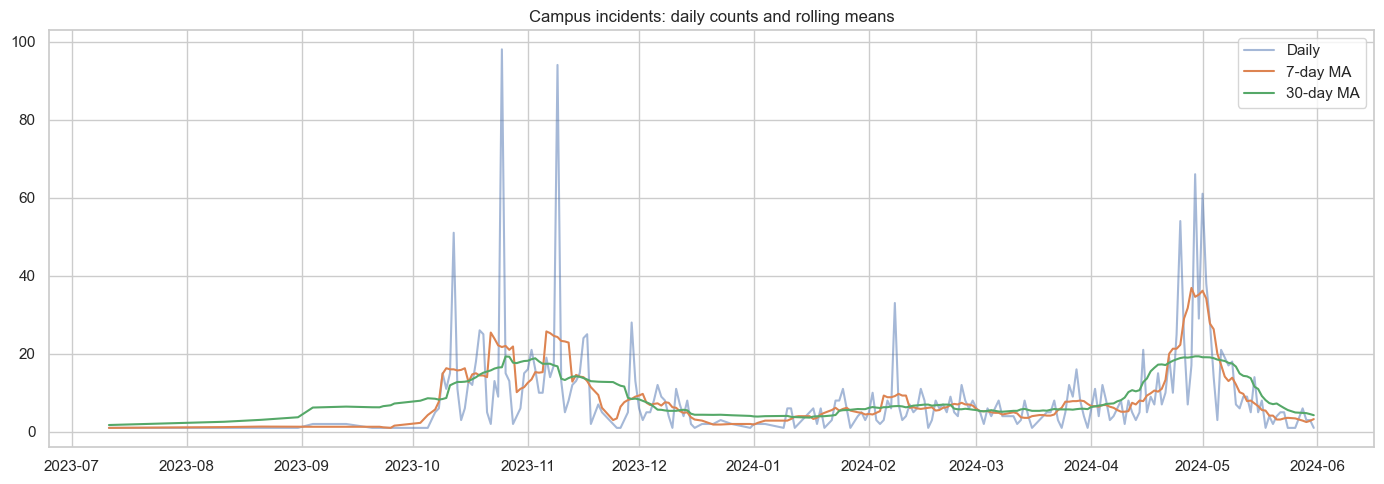

In [10]:
# 3.3 Time-series
daily['date'] = pd.to_datetime(daily['date'])
daily = daily.sort_values('date')
daily['rolling7'] = daily['incidents'].rolling(7, center=True, min_periods=1).mean()
daily['rolling30'] = daily['incidents'].rolling(30, center=True, min_periods=1).mean()

plt.figure(figsize=(14,5))
plt.plot(daily['date'], daily['incidents'], alpha=0.5, label='Daily')
plt.plot(daily['date'], daily['rolling7'], label='7-day MA')
plt.plot(daily['date'], daily['rolling30'], label='30-day MA')
plt.legend()
plt.title('Campus incidents: daily counts and rolling means')
plt.tight_layout()
plot_path = OUT_DIR / 'daily_time_series.png'
plt.savefig(plot_path)
print('Saved', plot_path)
plt.show()

## Notebook 3 — Incident-type breakdowns and top campuses
Show counts by incident type and top campuses.

Saved incidents_by_type.png


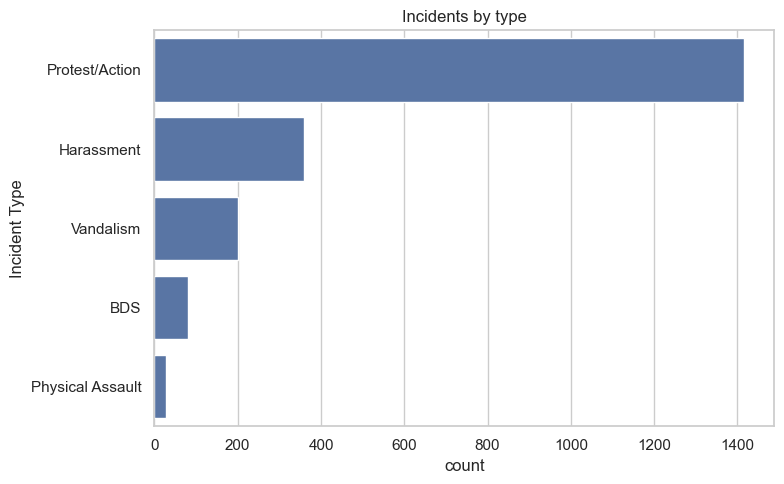

,college,count
0,Columbia University,50
1,University of Michigan,38
2,Harvard University,36
3,"University of California, Berkeley",36
4,"University of California, Los Angeles",35


In [11]:
# 3.4 Incident type breakdown
types = clean['Incident Type'].value_counts().reset_index()
types.columns = ['Incident Type', 'count']
plt.figure(figsize=(8,5))
sns.barplot(data=types, x='count', y='Incident Type')
plt.title('Incidents by type')
plt.tight_layout()
plt.savefig(OUT_DIR / 'incidents_by_type.png')
print('Saved incidents_by_type.png')
plt.show()

# Top campuses
top_campuses = clean['college_canonical'].value_counts().head(20).reset_index()
top_campuses.columns = ['college', 'count']
top_campuses.head()

## Notebook 3 — Basic NLP on Description
Compute top tokens and bigrams (basic). Wordcloud optional.

In [12]:
# 3.5 Basic NLP (token counts)
from collections import Counter
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

text_series = clean['description_clean'].dropna().astype(str)
all_text = ' '.join(text_series)
# simple tokenization
tokens = [t.lower() for t in re.findall(r"\b\w{3,}\b", all_text)]
filtered = [t for t in tokens if t not in stop]
most = Counter(filtered).most_common(30)
most[:20]

# Save top tokens
pd.DataFrame(most, columns=['token','count']).to_csv(OUT_DIR / 'top_tokens.csv', index=False)
print('Saved top_tokens.csv')

Saved top_tokens.csv


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ainsleyfreedman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Notebook 3 — Export figures and summary tables
List saved artifacts and show corrected Jewish-holiday metrics + matched raw rows (if present).

Artifacts in outputs:
 - /Users/ainsleyfreedman/projects/AntisemitismTrends/outputs/agg_daily.csv
 - /Users/ainsleyfreedman/projects/AntisemitismTrends/outputs/agg_monthly.csv
 - /Users/ainsleyfreedman/projects/AntisemitismTrends/outputs/agg_weekly.csv
 - /Users/ainsleyfreedman/projects/AntisemitismTrends/outputs/campus_reports.cleaned.csv
 - /Users/ainsleyfreedman/projects/AntisemitismTrends/outputs/canonical_jewish_holidays.csv
 - /Users/ainsleyfreedman/projects/AntisemitismTrends/outputs/daily_time_series.png
 - /Users/ainsleyfreedman/projects/AntisemitismTrends/outputs/f1_vs_threshold_best_holiday_model.png
 - /Users/ainsleyfreedman/projects/AntisemitismTrends/outputs/holiday_date_presence.csv
 - /Users/ainsleyfreedman/projects/AntisemitismTrends/outputs/holiday_keyword_matches.csv
 - /Users/ainsleyfreedman/projects/AntisemitismTrends/outputs/incidents_by_type.png
 - /Users/ainsleyfreedman/projects/AntisemitismTrends/outputs/incidents_on_jewish_holidays_daily.csv
 - /Users/ainsleyf

,protests_on_jh,nonprotests_on_jh,protests_not_jh,nonprotests_not_jh,total_jh_days,total_not_jh_days,protest_rate_jh,protest_rate_not_jh,fisher_pvalue,fisher_oddsratio
0,29,17,172,108,46,280,0.630435,0.614286,0.87154,1.071135



Matched raw rows (first 30):


,Date of Incident,City of Incident,State of Incident,Incident Type,Description,College/University,Date,is_protest_row
0,9/25/23,Washington,Washington D.C.,Protest/Action,The Jewish Voice for Peace (JVP) chapter at Ge...,George Washington University,2023-09-25,1
1,10/3/23,New Brunswick,New Jersey,Harassment,"""From the river to the sea, Free Palestine"" wa...","Rutgers University, New Brunswick",2023-10-03,0
2,10/5/23,Columbus,Ohio,Vandalism,"Patriot Front, a white supremacist group, post...",Ohio State University,2023-10-05,0
3,10/7/23,Suffern,New York,Harassment,A student at Rockland Community College receiv...,Rockland Community College,2023-10-07,0
4,10/7/23,Stanford,California,Protest/Action,Multiple banners were hung on campus buildings...,Stanford University,2023-10-07,1
5,10/7/23,Philadelphia,Pennsylvania,Harassment,"Individuals yelled, ""Shame!"" and ""Terrorists"" ...",Temple University,2023-10-07,0
6,10/7/23,Riverside,California,Harassment,"Hillel of the University of California, Rivers...","University of California, Riverside",2023-10-07,0
7,10/7/23,Wellesley,Massachusetts,Harassment,Residence hall leaders at Wellesley College se...,Wellesley College,2023-10-07,0
8,10/8/23,Tempe,Arizona,Protest/Action,"At Arizona State University, the Students for ...",Arizona State University,2023-10-08,1
9,10/8/23,San Luis Obispo,California,Harassment,"An individual in a passing vehicle yelled, ""De...","California Polytechnic State University, San L...",2023-10-08,0


Showing: /Users/ainsleyfreedman/projects/AntisemitismTrends/outputs/protest_rate_by_jewish_holiday_corrected.png


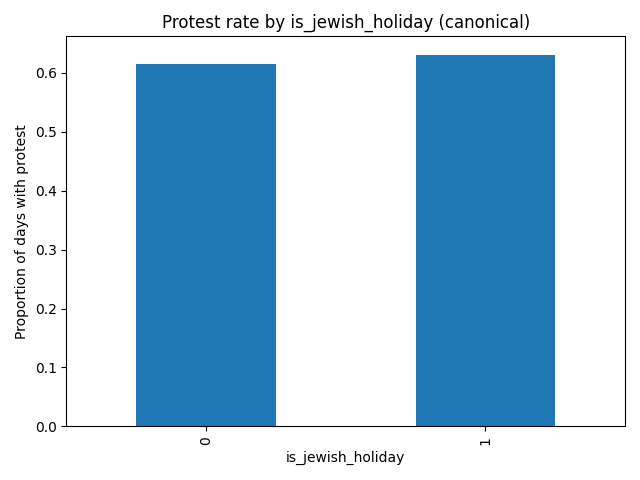

Showing: /Users/ainsleyfreedman/projects/AntisemitismTrends/outputs/pr_curve_best_holiday_model.png


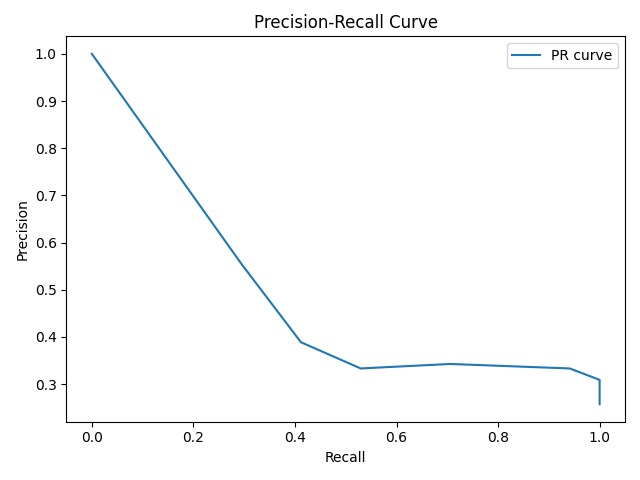

Showing: /Users/ainsleyfreedman/projects/AntisemitismTrends/outputs/daily_time_series.png


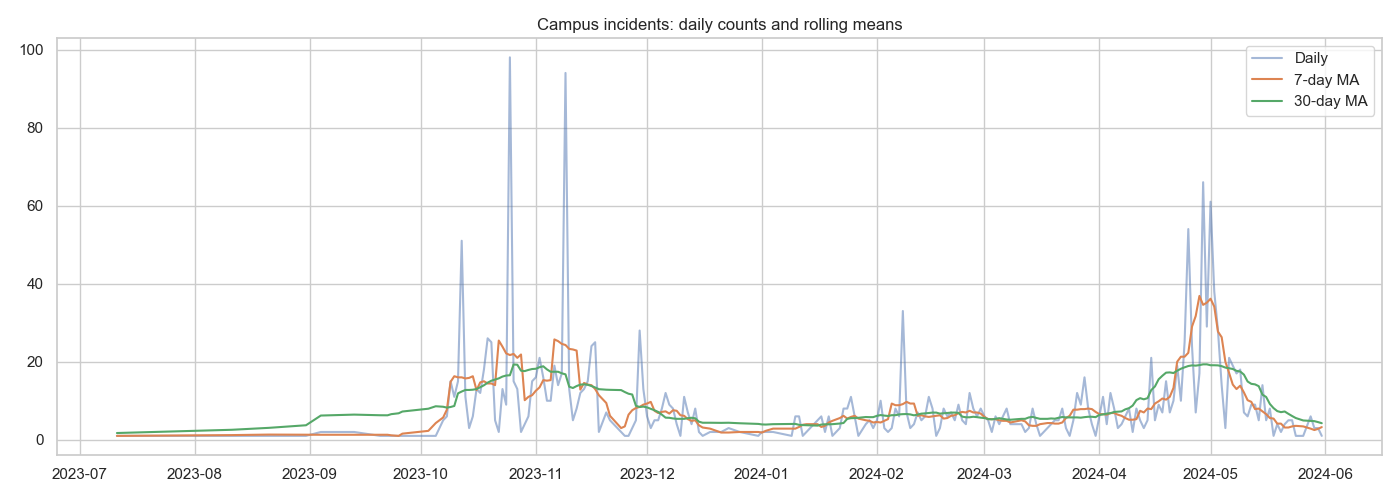

In [13]:
# 3.6 Show saved artifacts and the corrected metrics + matched rows
artifacts = sorted([str(p) for p in OUT_DIR.glob('*')])
print('Artifacts in outputs:')
for a in artifacts:
    print(' -', a)

# Display corrected metrics CSV if present
if METRICS_CSV.exists():
    print('\nCorrected Jewish-holiday metrics:')
    display(pd.read_csv(METRICS_CSV))
else:
    print('\nNo corrected metrics CSV found at', METRICS_CSV)

# Display matched raw rows
if MATCHED_RAW.exists():
    print('\nMatched raw rows (first 30):')
    matched = pd.read_csv(MATCHED_RAW)
    display(matched.head(30))
else:
    print('\nNo matched raw rows file found at', MATCHED_RAW)

# Display relevant plots if present
from IPython.display import Image, display
for p in [RATE_PLOT, PR_PLOT, OUT_DIR / 'daily_time_series.png']:
    if Path(p).exists():
        print('Showing:', p)
        display(Image(str(p)))
    else:
        print('Missing plot:', p)

## Short Summary — Jewish-holiday vs protest check (from pipeline)
- Contingency and Fisher exact test were computed in the pipeline and saved to `outputs/protest_jewish_holiday_metrics_corrected.csv`.
- The pipeline-run result (using the user-provided canonical holiday ranges) yielded roughly similar protest rates on Jewish holidays vs non-holidays; see the metrics table above for exact counts and p-value.